In [2]:
import numpy as np
import torch
import pretty_midi as pm
import matplotlib.pyplot as plt
import os

if not os.path.exists('./demo'):
    os.mkdir('./demo')

## Part one: EC$^2$-VAE

Let's first preprare the pre-trained model. We first initialize our model structure and then load its parameters.
* The model structure is defined in the class `ec2vae.model.EC2VAE`. 
* The model parameter is saved in a `.pt` file.

In [3]:
from ec2vae.model import EC2VAE

In [4]:
# initialize the model
ec2vae_model = EC2VAE.init_model()

# load model parameter
ec2vae_param_path = './ec2vae/model_param/ec2vae-v1.pt'
ec2vae_model.load_model(ec2vae_param_path)

Then, let's prepare some data and manipulate their latent codes. We use an array of length 32 to represent a 2-bar melody, where each time step corresponds to a 16-th note: 0-127 are MIDI pitches, 128 for sustain, and 130 for rest.

In [156]:
# # 1
# version_num = 1
# x1 = np.array([60, 128, 128, 128, 60, 128, 128, 128, 65, 128, 128, 128, 65, 128, 128, 128,
#                64, 128, 128, 128, 64, 128, 128, 128, 67, 128, 128, 128, 67, 128, 128, 128])

# x2 = np.array([72, 128, 128, 128, 72, 128, 128, 128, 64, 128, 128, 128, 64, 128, 128, 128,
#                62, 128, 128, 128, 62, 128, 128, 128, 60, 128, 128, 128, 60, 128, 128, 128])

# x3 = np.array([60, 128, 128, 128, 60, 128, 128, 128, 62, 128, 128, 128, 62, 128, 128, 128,
#                61, 128, 128, 128, 61, 128, 128, 128, 65, 128, 128, 128, 65, 128, 128, 128])

# # 2
# version_num = 2
# x1 = np.array([60, 128, 128, 128, 60, 128, 128, 128, 67, 128, 128, 128, 67, 128, 128, 128,
#                65, 128, 128, 128, 65, 128, 128, 128, 64, 128, 128, 128, 64, 128, 128, 128])

# x2 = np.array([72, 128, 128, 128, 72, 128, 128, 128, 64, 128, 128, 128, 64, 128, 128, 128,
#                67, 128, 128, 128, 67, 128, 128, 128, 65, 128, 128, 128, 65, 128, 128, 128])

# x3 = np.array([60, 128, 128, 128, 60, 128, 128, 128, 68, 128, 128, 128, 68, 128, 128, 128,
#                67, 128, 128, 128, 67, 128, 128, 128, 65, 128, 128, 128, 65, 128, 128, 128])

# 3
version_num = 3
x1 = np.array([60, 128, 128, 128, 60, 128, 128, 128, 67, 128, 128, 128, 67, 128, 128, 128,
               64, 128, 128, 128, 64, 128, 128, 128, 67, 128, 128, 128, 67, 128, 128, 128])

x2 = np.array([72, 128, 128, 128, 72, 128, 128, 128, 65, 128, 128, 128, 65, 128, 128, 128,
               67, 128, 128, 128, 67, 128, 128, 128, 64, 128, 128, 128, 64, 128, 128, 128])

x3 = np.array([60, 128, 128, 128, 60, 128, 128, 128, 68, 128, 128, 128, 68, 128, 128, 128,
               65, 128, 128, 128, 65, 128, 128, 128, 68, 128, 128, 128, 68, 128, 128, 128])

We'll need to turn note arrays into one-hot vectors, i.e., piano-rolls.

In [157]:
def note_array_to_onehot(note_array):
    pr = np.zeros((len(note_array), 130))
    pr[np.arange(0, len(note_array)), note_array.astype(int)] = 1.
    return pr

pr1 = note_array_to_onehot(x1)
pr2 = note_array_to_onehot(x2)
pr3 = note_array_to_onehot(x3)

Melody should be further converted to pytorch tensors, and to cuda/cpu. We should also unsqueeze a batch dimension.

In [158]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pr1 = torch.from_numpy(pr1).float().to(device).unsqueeze(0)
pr2 = torch.from_numpy(pr2).float().to(device).unsqueeze(0)
pr3 = torch.from_numpy(pr3).float().to(device).unsqueeze(0)

print(pr1.size())

torch.Size([1, 32, 130])


Next, define the chords. In EC$^2$-VAE, we use 12-dim chord chroma representation. Chord is a time-series consisting of 32 tokens (16-th notes).

In [159]:
# no chord
c3 = np.zeros((32, 12))
c3 = torch.from_numpy(c3).float().to(device).unsqueeze(0)

Start to run model. Encode $z_p$ and $z_r$ by calling the encoder.
    

In [160]:
# encode melody and no chord
zp1, zr1 = ec2vae_model.encoder(pr1, c3)
zp2, zr2 = ec2vae_model.encoder(pr2, c3)
zp3, zr3 = ec2vae_model.encoder(pr3, c3)

print(zp1.size(), zr1.size())

torch.Size([1, 128]) torch.Size([1, 128])


In [161]:
# Interpolate
from numpy import *
from numpy.linalg import norm

def slerp(p0, p1, t):
    omega = arccos(dot(p0/norm(p0), p1/norm(p1)))
    so = sin(omega)
    return sin((1.0-t)*omega) / so * p0 + sin(t*omega)/so * p1

def interpolate(pA, pB):
    pA = pA.cpu().numpy().squeeze(0)
    pB = pB.cpu().numpy().squeeze(0)
    ps = array([slerp(pA, pB, t) for t in arange(0.0, 1.1, 0.25)])
    return ps

In [162]:
from1to2 = list(zip(interpolate(zp1, zp2), interpolate(zr1, zr2)))
from1to3 = list(zip(interpolate(zp1, zp3), interpolate(zr1, zr3)))

In [163]:
from scipy.io.wavfile import write
import librosa.display

def generate_midi(mel_notes):
    midi = pm.PrettyMIDI()
    ins1 = pm.Instrument(0)
    ins1.notes = mel_notes
    midi.instruments.append(ins1)
    return midi 

def save_midi_as_wav(fn, midi):
    audio = midi.synthesize()
    write(fn, 44100, audio)

def plot_piano_roll(midi, start_pitch, end_pitch, fs=100):
    librosa.display.specshow(midi.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pm.note_number_to_hz(start_pitch))

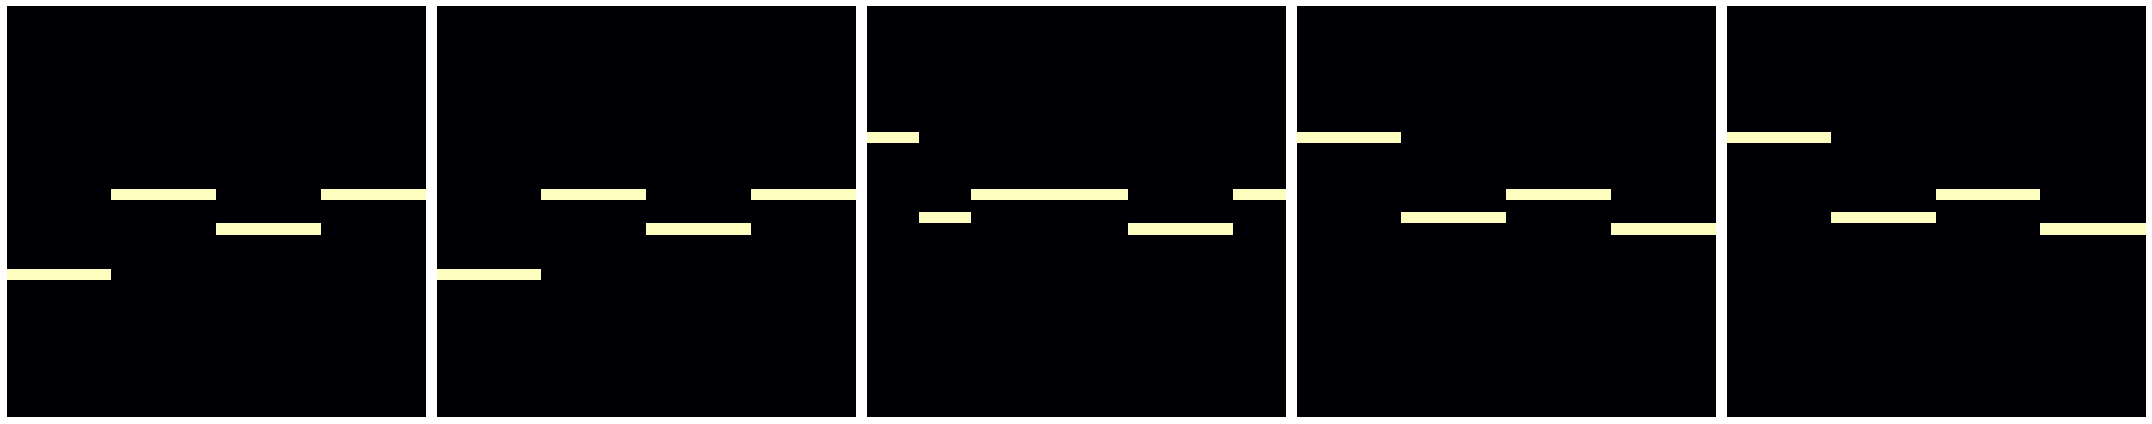

In [164]:
plt.figure(figsize=(30, 6))

for i, (zp, zr) in enumerate(from1to2):
    # Generate midi
    zp = torch.from_numpy(zp).float().to(device).unsqueeze(0)
    zr = torch.from_numpy(zr).float().to(device).unsqueeze(0)
    pred = ec2vae_model.decoder(zp, zr, c3)
    pred = pred.squeeze(0).cpu().numpy()
    notes = ec2vae_model.__class__.note_array_to_notes(pred, bpm=150, start=0.)
    midi = generate_midi(notes)

    # Plot the notes
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plot_piano_roll(midi, 48, 84)

    # Save as wav
    save_midi_as_wav(f'./demo_long/{version_num}/contour_change_{i+1}.wav', midi)

plt.tight_layout()
plt.savefig(f'./demo_long/{version_num}/contour_change_png')

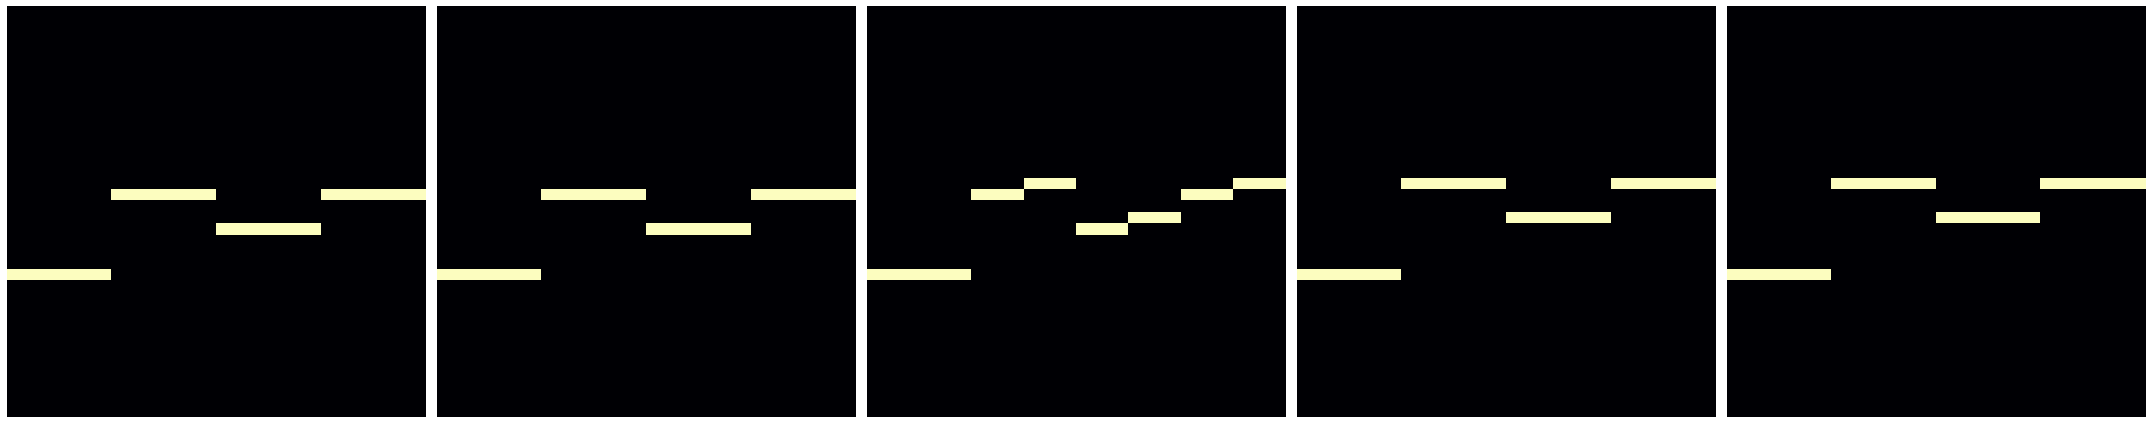

In [165]:
plt.figure(figsize=(30, 6))

for i, (zp, zr) in enumerate(from1to3):
    # Generate midi
    zp = torch.from_numpy(zp).float().to(device).unsqueeze(0)
    zr = torch.from_numpy(zr).float().to(device).unsqueeze(0)
    pred = ec2vae_model.decoder(zp, zr, c3)
    pred = pred.squeeze(0).cpu().numpy()
    notes = ec2vae_model.__class__.note_array_to_notes(pred, bpm=150, start=0.)
    midi = generate_midi(notes)

    # Plot the notes
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plot_piano_roll(midi, 48, 84)

    # Save as wav
    save_midi_as_wav(f'./demo_long/{version_num}/chord_change_{i+1}.wav', midi)

plt.tight_layout()
plt.savefig(f'./demo_long/{version_num}/chord_change_png')